In [1]:
using Knet

In [2]:
mutable struct Corpus
    vocabid
    vocab
end

function Corpus()
    vocabid = Dict()
    vocabid = Dict("" => 1) # both padding and whitespace KnetArray(zeros(EMBEDDING_SIZE))
    vocab = param(reshape(KnetArray{Float32}(zeros(EMBEDDING_SIZE)),(EMBEDDING_SIZE,1)))
    return Corpus(vocabid,vocab)
end

Corpus

In [3]:
mutable struct MultilayerPerceptron
    layers
    MultilayerPerceptron(layers...) = new(layers)
end
(m::MultilayerPerceptron)(x) = (for l in m.layers; x = l(x); end; x)

In [4]:
struct Layer0; w; b; end
Layer0(ir::Int, ic::Int, o::Int) = Layer0(param(o,ir),param0(o, ic))
(l::Layer0)(x) = (l.w * x .+ l.b)

In [5]:
#=
mutable struct EmbedModel
    w
end
=#

In [6]:
#=
function EmbedModel()
    dim1 = 30
    dim2 = 64 #EMBEDDING_SIZE
    dim3 = 32
    w = Param(reshape(KnetArray{Float32}(Knet.xavier(dim1*dim2*dim3)), (1,dim1,dim2,dim3)))
    return EmbedModel(w)
end
=#

In [7]:
#=
function (e::EmbedModel)(x)
    output = conv4(value(e.w), x, dilation=2)
    return output
end
=#

In [8]:
struct ConvModel; w; b; f; end
(c::ConvModel)(x) = c.f.(conv4(c.w, x, dilation=2) .+ c.b)
ConvModel(w1,w2,cx,cy,f=relu) = ConvModel(param(w1,w2,cx,cy), param0(1,2,cy,1), f)

ConvModel

In [9]:
mutable struct CaptionEncoder
    conv_model
    corpus
end

In [10]:
function CaptionEncoder()
    dim1 = 30
    dim2 = 64 #EMBEDDING_SIZE
    dim3 = 32
    conv_model = ConvModel(1,dim1,dim2,dim3)
    corpus = Corpus()
    return CaptionEncoder(conv_model, corpus)
end

CaptionEncoder

In [11]:
function (c::CaptionEncoder)(captions)
    caption_embeds = arrange(captions, c.corpus)
    input = createconvinput(caption_embeds)
    input = reshape(input, (1, MAX_LENGTH, EMBEDDING_SIZE, BATCH_SIZE*NUM_CAPTIONS_PER_SCENE))
    di_hat = c.conv_model(input)
    captions_hat = reshape(reshape(di_hat, (2, 32, BATCH_SIZE*NUM_CAPTIONS_PER_SCENE)), (EMBEDDING_SIZE, BATCH_SIZE*NUM_CAPTIONS_PER_SCENE))
    return captions_hat
end

In [12]:
mutable struct AngleEncoder
    mlp_model
end

In [13]:
function AngleEncoder()
    dim1 = 2 # cos and sin
    dim2 = BATCH_SIZE*NUM_CAPTIONS_PER_SCENE
    dim3 = 32 # from paper
    mlp1=MultilayerPerceptron(Layer0(dim1, dim2, dim3)) # MLP1 dimensionality 32
    return AngleEncoder(mlp1)
end

AngleEncoder

In [14]:
function (a::AngleEncoder)(cameras)
    tuples = build_angles(cameras)
    cameras_hat = a.mlp_model(tuples)
    return cameras_hat
end

In [15]:
#=
mutable struct ImageConvModel
    w
end
=#

In [16]:
#=
function ImageConvModel()
    dim1 = 17
    dim2 = 17
    dim3 = 3 # RGB
    w = reshape(KnetArray{Float32}(Knet.xavier(dim1*dim2*dim3)), (dim1,dim2,dim3,1))
    return ImageConvModel(w)
end
=#

In [17]:
#=
function (i::ImageConvModel)(x)
    output = conv4(i.w, x)
    return output
end
=#

In [18]:
mutable struct ImageConvModel; w; b; f; end
(i::ImageConvModel)(x) = i.f.(conv4(i.w, x) .+ i.b)
ImageConvModel(w1,w2,cx,cy,f=relu) = ImageConvModel(param(w1,w2,cx,cy), param0(16,16,cy,1), f)

ImageConvModel

In [19]:
mutable struct SamplingModel
    mu_layer
    logsigma_layer
end

In [20]:
function SamplingModel()
    mu_layer = Layer0(256,50,162)
    logsigma_layer = Layer0(256, 50, 162)
    return SamplingModel(mu_layer, logsigma_layer)
end

SamplingModel

In [21]:
function (s::SamplingModel)(himg)
    mu = s.mu_layer(himg)
    #mu = reshape(mu, (162,50))
    logsigma = s.logsigma_layer(himg)
    #logsigma = reshape(logsigma, (162,50))
    sigma = exp.(logsigma)
    noise = randn!(similar(mu)) #162x50
    z = mu .+ noise .* sigma
    return (z, mu, sigma, logsigma) # z 162x50
end

In [22]:
mutable struct RepresentationModel
    caption_encoder
    angle_encoder
    #image_encoder
    mlp_model #mlp2 that takes concatenated di_hat and ci_hat, output = hi_hat
end

In [23]:
function RepresentationModel()
    caption_encoder = CaptionEncoder()
    angle_encoder = AngleEncoder()
    #image_encoder = ImageEncoder()
    mlp_model = MultilayerPerceptron(Layer0(96, 500, 128), Layer0(128, 500, 196), Layer0(196, 500, 256)) # MLP2 dimensionality 256
   return RepresentationModel(caption_encoder, angle_encoder, mlp_model) # image_encoder, 
end

RepresentationModel

In [24]:
function (re::RepresentationModel)(captions, cameras) #images, 
    captions_hat = re.caption_encoder(captions)
    cameras_hat = re.angle_encoder(cameras)
    
    # move!
    unseen_ang = []
    for i in 1:size(cameras_hat, 2)
        if mod(i,10) == 0
           push!(unseen_ang, cameras_hat[:,i]) 
        end
    end
    unseen_ang = hcat(unseen_ang...)
    
    h = re.mlp_model(cat(captions_hat, cameras_hat, dims=1))
    r = aggregate(h)
    # z = re.image_encoder(images)
    
    return r, unseen_ang # z,
end

In [25]:
mutable struct ImageEncoder
    cv_linear_model
    image_conv_model
    sampling_model
end

In [26]:
function ImageEncoder()
    cv_linear_model = Layer0(288, 50, 1024)
    image_conv_model = ImageConvModel(17, 17, 4, 1)
    sampling_model = SamplingModel()
    return ImageEncoder(cv_linear_model, image_conv_model, sampling_model)
end

ImageEncoder

In [27]:
#=
function (i::ImageEncoder)(images)
    imgencoderin = createimgencinput(images) #9unu alıyo
    imgencoderin2 = pool(imgencoderin, window=4, stride=4)
    himg = i.image_conv_model(imgencoderin2)
    himg = himg[:,:,1,:]
    himg = reshape(himg, (256,450))
    z, mu, logsigma, sigma = i.sampling_model(himg)
    return (z, mu, logsigma, sigma)
end
=#

In [28]:
function (i::ImageEncoder)(images, cv)
    imgencoderin1 = creategoldimg(images) # 32x32x3x50
    imgencoderin2 = cat(imgencoderin1, reshape(i.cv_linear_model(cv), (32, 32, 1, 50)), dims=3)
    himg = i.image_conv_model(imgencoderin2)
    himg = himg[:,:,1,:]
    himg = reshape(himg, (256,50))
    z, mu, sigma, logsigma = i.sampling_model(himg)
    return (z, mu, sigma, logsigma)
end

In [29]:
mutable struct ImageDecoder; w; b; f; end
(im::ImageDecoder)(x) = relu.(deconv4(im.w, x) .+ im.b)
ImageDecoder() = ImageDecoder(param(32,32,3,450), param0(32,32,3,1), relu)

ImageDecoder

In [30]:
mutable struct GenerationModel
    image_encoder
    image_decoder
end

In [31]:
function GenerationModel()
    image_encoder = ImageEncoder()
    image_decoder = ImageDecoder()
    return GenerationModel(image_encoder, image_decoder)
end

GenerationModel

In [32]:
function (ge::GenerationModel)(images, conditional_variable)
    z, mu, sigma, logsigma = ge.image_encoder(images, conditional_variable)
    gen_input = reshape(vcat(z, conditional_variable),(1,1,450,50)) # decoder input
    rimages = ge.image_decoder(gen_input)
    return rimages, mu, sigma, logsigma
end

In [33]:
#=
function GenerationModel()
    dim1 = 32
    dim2 = 32
    dim3 = 3 # RGB
    dim4 = 450
    w = reshape(KnetArray{Float32}(Knet.xavier(dim3*dim1*dim2*dim4)), (dim1,dim2,dim3,dim4))
    return GenerationModel(w)
end
=#

In [34]:
#=
function (g::GenerationModel)(x)
    final_output = deconv4(g.w, x)
    return final_output
end
=#

In [35]:
mutable struct Output
    rimages
    mu
    sigma
    logsigma
end

In [36]:
mutable struct Network
    representationModel
    generationModel
end

In [37]:
function Network()
    representationModel = RepresentationModel()
    generationModel = GenerationModel()
    return Network(representationModel, generationModel)
end

Network

In [38]:
function (n::Network)(images, captions, cameras)
    r, unseen_ang = n.representationModel(captions, cameras) #images,  z,
    conditional_variable = vcat(r, unseen_ang)
    rimages, mu, sigma, logsigma = n.generationModel(images, conditional_variable)
    return Output(rimages, mu, sigma, logsigma)
end

In [39]:
include("slim_reader.jl")
include("Encoder.jl")
using Knet, ImageMagick, Colors, Images, Sloth, DRAW, Random
BATCH_SIZE = 50
EPOCH = 100
NUMBATCHES = 100
slim_data_dir = "/home/ec2-user/efs/slim-dataset"
syn_train_files = Slim_Reader.get_train_filenames(slim_data_dir, true, false)
# Construct training dataset object for synthetic data
syn_train_data = Slim_Reader.make_dataset_object(syn_train_files, BATCH_SIZE)
syn_train_batch = Slim_Reader.get_next_batch(syn_train_data, KnetArray{Float32}, false, true);
images, captions, cameras = getdata(syn_train_batch)

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at slim_reader.jl:6
└ @ Core /home/ec2-user/comp492/Text2Image-cemil-slim-dataset-reader/slim_reader.jl:6
┌ Info: Recompiling stale cache file /home/ec2-user/.julia/compiled/v1.2/DRAW/AGNCk.ji for DRAW [7e16b5a0-e062-11e9-3467-b7e39d9ee233]
└ @ Base loading.jl:1240
┌ Warning: Package DRAW does not have Sloth in its dependencies:
│ - If you have DRAW checked out for development and have
│   added Sloth as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with DRAW
└ Loading Sloth into DRAW from project dependency, future warnings for DRAW are suppressed.





Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.



2019-12-18 18:03:31.700752: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2019-12-18 18:03:31.751371: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300070000 Hz
2019-12-18 18:03:31.751816: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x83c53a0 executing computations on platform Host. Devices:
2019-12-18 18:03:31.751841: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
OMP: Info #212: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #210: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-3
OMP: Info #156: KMP_AFFINITY: 4 available OS procs
OMP: Info #157: K

(K32(50,10,128,128,3)[0.6039216⋯], ["There is a large blue box behind a large mint cylinder. The box is behind the cylinder.  " "There is a large blue box to the left of a large mint cylinder.  " … "There is a large mint cylinder behind a large blue box. The cylinder is behind the box.  " "There is a large mint cylinder behind a large blue box. The cylinder is behind the box.  "; "There is a large red capsule in front of a blue cone. The capsule is to the left of the cone. There is a large red capsule to the left of a magenta ico. There is a magenta ico close to a blue cone. The ico is to the left of the cone.  " "There is a blue cone to the right of a large red capsule. The cone is behind the capsule. There is a magenta ico to the right of a large red capsule. There is a magenta ico close to a blue cone. The ico is to the left of the cone.  " … "There is a blue cone behind a large red capsule. The cone is to the left of the capsule. There is a large red capsule in front of a magenta i

In [40]:
n = Network()

Network(RepresentationModel(CaptionEncoder(ConvModel(P(KnetArray{Float32,4}(1,30,64,32)), P(KnetArray{Float32,4}(1,2,32,1)), NNlib.relu), Corpus(Dict("" => 1), P(KnetArray{Float32,2}(64,1)))), AngleEncoder(MultilayerPerceptron((Layer0(P(KnetArray{Float32,2}(32,2)), P(KnetArray{Float32,2}(32,500))),))), MultilayerPerceptron((Layer0(P(KnetArray{Float32,2}(128,96)), P(KnetArray{Float32,2}(128,500))), Layer0(P(KnetArray{Float32,2}(196,128)), P(KnetArray{Float32,2}(196,500))), Layer0(P(KnetArray{Float32,2}(256,196)), P(KnetArray{Float32,2}(256,500)))))), GenerationModel(ImageEncoder(Layer0(P(KnetArray{Float32,2}(1024,288)), P(KnetArray{Float32,2}(1024,50))), ImageConvModel(P(KnetArray{Float32,4}(17,17,4,1)), P(KnetArray{Float32,4}(16,16,1,1)), NNlib.relu), SamplingModel(Layer0(P(KnetArray{Float32,2}(162,256)), P(KnetArray{Float32,2}(162,50))), Layer0(P(KnetArray{Float32,2}(162,256)), P(KnetArray{Float32,2}(162,50))))), ImageDecoder(P(KnetArray{Float32,4}(32,32,3,450)), P(KnetArray{Float32,4

In [41]:
n(images, captions, cameras)

Output(K32(32,32,3,50)[0.0⋯], K32(162,50)[0.33728826⋯], K32(162,50)[1.5076095⋯], K32(162,50)[0.41052526⋯])

In [42]:
#=
function loss(n::Network, images, captions, cameras, y, loss_values) # y = gold
    output = n(images, captions, cameras)
    loss = bce(output, y)
    push!(loss_values, loss)
    return loss
end
=#

In [43]:
function loss(n::Network, images, captions, cameras, final_output_gold)
    output = n(images, captions, cameras)
    recon = bce(output.rimages, final_output_gold) #*32 *32 # neden 32*32 ile carptik
    mu_2 = DRAW.square(output.mu)
    kl = 0.5 * sum(output.sigma + mu_2 .- 1 - output.logsigma)
    return recon + kl
end

loss (generic function with 1 method)

In [44]:
output = n(images, captions, cameras)

Output(K32(32,32,3,50)[0.08671385⋯], K32(162,50)[0.33728826⋯], K32(162,50)[1.5076095⋯], K32(162,50)[0.41052526⋯])

In [45]:
total_loss = loss(n, images, captions, cameras, final_output_gold)

UndefVarError: UndefVarError: final_output_gold not defined

In [46]:
# train!@DRAW correspondence
function update_weights!(n::Network, images, captions, cameras, y)
    J = @diff loss(n, images, captions, cameras, y)
    for par in params(n)
        g = grad(J, par)
        update!(value(par), g; lr=0.1)
    end
    return value(J)
end

update_weights! (generic function with 1 method)

100

In [47]:
function epoch!(n::Network, syn_train_data) # last loss = loss before last update
    loss_values = []
    for i in 1:EPOCH
        for j in 1:NUMBATCHES
            syn_train_batch = Slim_Reader.get_next_batch(syn_train_data, KnetArray{Float32}, false, true)
            images, captions, cameras = getdata(syn_train_batch)
            y = creategoldimg(images)
            loss = update_weights!(n, images, captions, cameras, y)
            push!(loss_values, loss)
        end
    end
    return loss_values
end

epoch! (generic function with 1 method)

In [48]:
final_output_gold = creategoldimg(images)

32×32×3×50 KnetArray{Float32,4}:
[:, :, 1, 1] =
 0.603922  0.603922  0.603922  0.603922  …  0.603922  0.603922  0.603922
 0.603922  0.603922  0.603922  0.603922     0.603922  0.603922  0.603922
 0.603922  0.603922  0.603922  0.603922     0.603922  0.603922  0.603922
 0.603922  0.603922  0.603922  0.603922     0.603922  0.603922  0.603922
 0.603922  0.603922  0.603922  0.603922     0.603922  0.603922  0.603922
 0.603922  0.603922  0.603922  0.603922  …  0.603922  0.603922  0.603922
 0.603922  0.603922  0.603922  0.603922     0.603922  0.603922  0.603922
 0.603922  0.603922  0.603922  0.603922     0.603922  0.603922  0.603922
 0.698039  0.690196  0.627451  0.639216     0.666667  0.682353  0.666667
 0.321569  0.584314  0.65098   0.666667     0.643137  0.623529  0.588235
 0.376471  0.364706  0.368627  0.345098  …  0.721569  0.701961  0.701961
 0.380392  0.368627  0.364706  0.34902      0.717647  0.72549   0.690196
 0.34902   0.372549  0.368627  0.34902      0.654902  0.682353  0.690196
 ⋮ 

In [49]:
update_weights!(n, images, captions, cameras, final_output_gold)

31.65240752696991

In [50]:
losses = epoch!(n, syn_train_data)


Stacktrace:
 [1] (::getfield(CUDAnative, Symbol("#kw#HostKernel")))(::NamedTuple{(:blocks, :threads),Tuple{Tuple{Int64},Tuple{Int64}}}, ::CUDAnative.HostKernel{GPUArrays.setindex_kernel!,Tuple{CuArrays.CuKernelState,CUDAnative.CuDeviceArray{Float32,3,CUDAnative.AS.Global},CUDAnative.CuDeviceArray{Float32,2,CUDAnative.AS.Global},Tuple{Int64,Int64,Int64},Tuple{UnitRange{Int64},UnitRange{Int64},UnitRange{Int64}},Int64}}, ::CuArrays.CuKernelState, ::Vararg{Any,N} where N) at ./none:0
 [2] _gpu_call(::CuArrays.CuArrayBackend, ::Function, ::CuArrays.CuArray{Float32,3}, ::Tuple{CuArrays.CuArray{Float32,3},CuArrays.CuArray{Float32,2},Tuple{Int64,Int64,Int64},Tuple{UnitRange{Int64},UnitRange{Int64},UnitRange{Int64}},Int64}, ::Tuple{Tuple{Int64},Tuple{Int64}}) at /home/ec2-user/.julia/packages/CUDAnative/Lr0yj/src/execution.jl:176
 [3] gpu_call(::Function, ::CuArrays.CuArray{Float32,3}, ::Tuple{CuArrays.CuArray{Float32,3},CuArrays.CuArray{Float32,2},Tuple{Int64,Int64,Int64},Tuple{UnitRange{Int6

InterruptException: InterruptException:

In [55]:
function predict(n, captions, cameras)   #(n::Network, images, captions, cameras)
    r, unseen_ang = n.representationModel(captions, cameras)
    conditional_variable = vcat(r, unseen_ang)
    mu = KnetArray{Float32}(Knet.zeros(162,50))
    sigma = KnetArray{Float32}(Knet.ones(162,50))
    z = mu .+ randn!(similar(mu)) .* sigma
    decinput = reshape(vcat(z, conditional_variable), (1,1,450,50))
    rimages = n.generationModel.image_decoder(decinput)
    return rimages
end

predict (generic function with 1 method)

In [56]:
syn_test_files = Slim_Reader.get_test_filenames(slim_data_dir, true, false)
# Construct training dataset object for synthetic data
syn_test_data = Slim_Reader.make_dataset_object(syn_test_files, BATCH_SIZE)
syn_test_batch = Slim_Reader.get_next_batch(syn_test_data, KnetArray{Float32}, false, true);
tstimages, tstcaptions, tstcameras = getdata(syn_test_batch)

OMP: Info #250: KMP_AFFINITY: pid 6838 tid 6876 thread 2 bound to OS proc set 2


(K32(50,10,128,128,3)[0.6039216⋯], ["There is a pink cylinder behind a pink cone. The cylinder is behind the cone.  " "There is a pink cylinder in front of a pink cone. The cylinder is to the left of the cone.  " … "There is a pink cone behind a pink cylinder. The cone is to the right of the cylinder.  " "There is a pink cone behind a pink cylinder. The cone is behind the cylinder.  "; "There is a pink cylinder behind a large purple capsule. The cylinder is behind the capsule. There is a large aqua cylinder to the right of a large purple capsule. There is a large aqua cylinder in front of a pink cylinder. The cylinder is to the right of the cylinder.  " "There is a pink cylinder behind a large purple capsule. The cylinder is behind the capsule. There is a large aqua cylinder to the right of a large purple capsule. There is a large aqua cylinder in front of a pink cylinder. The cylinder is to the right of the cylinder.  " … "There is a pink cylinder behind a large purple capsule. The cy

In [65]:
pred_images = predict(n, tstcaptions, tstcameras) 

32×32×3×50 KnetArray{Float32,4}:
[:, :, 1, 1] =
 0.144883   0.0         0.271977    …  0.130868   0.0914762   0.136412 
 0.0436406  0.0         0.0            0.0        0.0         0.0      
 0.19581    0.316396    0.0            0.160208   0.0         0.170202 
 0.0        0.0         0.0150316      0.0        0.0         0.0      
 0.113265   0.0         0.0            0.0878324  0.0         0.0      
 0.130017   0.0741409   0.164244    …  0.24987    0.0         0.0      
 0.0        0.0         0.131424       0.145589   0.0         0.0      
 0.0281259  0.0         0.0            0.0323752  0.00219946  0.359037 
 0.0        0.0         0.0598441      0.0        0.0         0.0      
 0.36274    0.140859    0.183438       0.206241   0.0340793   0.0      
 0.176609   0.0         0.231333    …  0.0        0.0346231   0.0      
 0.29754    0.0         0.0            0.0        0.0         0.0      
 0.28967    0.0         0.0401276      0.0        0.0         0.142724 
 ⋮              

In [62]:
true_images = creategoldimg(tstimages)

32×32×3×50 KnetArray{Float32,4}:
[:, :, 1, 1] =
 0.603922  0.603922  0.603922  0.603922  …  0.603922  0.603922  0.603922
 0.603922  0.603922  0.603922  0.603922     0.603922  0.603922  0.603922
 0.603922  0.603922  0.603922  0.603922     0.603922  0.603922  0.603922
 0.603922  0.603922  0.603922  0.603922     0.603922  0.603922  0.603922
 0.603922  0.603922  0.603922  0.603922     0.603922  0.603922  0.603922
 0.603922  0.603922  0.603922  0.603922  …  0.603922  0.603922  0.603922
 0.603922  0.603922  0.603922  0.603922     0.603922  0.603922  0.603922
 0.603922  0.603922  0.603922  0.603922     0.603922  0.603922  0.603922
 0.603922  0.615686  0.603922  0.603922     0.607843  0.607843  0.611765
 0.666667  0.662745  0.658824  0.654902     0.701961  0.670588  0.678431
 0.431373  0.67451   0.647059  0.635294  …  0.8       0.796078  0.772549
 0.419608  0.701961  0.701961  0.709804     0.811765  0.792157  0.796078
 0.439216  0.733333  0.713726  0.690196     0.788235  0.792157  0.792157
 ⋮ 

In [66]:
bce(pred_images, true_images)

0.6798526f0

In [39]:
#img = images[1,10,:,:,:]
out_img = out[:,:,:,1]
out_img = permutedims(out_img, (3,1,2))

3×32×32 KnetArray{Float32,3}:
[:, :, 1] =
 0.014426   0.0  0.0        0.0278805  …  0.0        0.0647074  0.021841 
 0.0219176  0.0  0.0124891  0.0882248     0.05305    0.0        0.0435004
 0.0        0.0  0.020858   0.0630064     0.0159227  0.038603   0.0993922

[:, :, 2] =
 0.115141   0.0        0.0  0.0309985  …  0.146225  0.0264258  0.0     
 0.102281   0.0887422  0.0  0.0           0.0       0.0486147  0.0     
 0.0553155  0.0        0.0  0.0           0.0       0.0        0.128827

[:, :, 3] =
 0.0        0.0  0.0273321  0.0919797  …  0.0        0.0  0.0      
 0.0        0.0  0.0        0.0           0.104341   0.0  0.0388329
 0.0303806  0.0  0.101443   0.0581996     0.0904196  0.0  0.0      

...

[:, :, 30] =
 0.0       0.0        0.110628   0.0        …  0.0       0.0349711  0.0      
 0.110156  0.0        0.0        0.0698677     0.135361  0.0        0.0663988
 0.0       0.0211705  0.0108166  0.0           0.11275   0.117262   0.0772231

[:, :, 31] =
 0.0782197  0.0  0.0  0

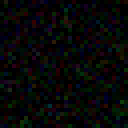

In [43]:
colorview(RGB, Array(out_img))

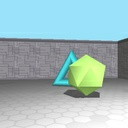

In [44]:
colorview(RGB, permutedims(Array(images[1,10,:,:,:]), (3,1,2)))

In [33]:
re = RepresentationModel()
rr, uunseen_ang = re(captions, cameras)

(K32(256,50)[-0.009070696⋯], K32(32,50)[-0.01595629⋯])

In [1]:
using Knet, DRAW, Sloth

┌ Info: Recompiling stale cache file /home/ec2-user/.julia/compiled/v1.2/DRAW/AGNCk.ji for DRAW [7e16b5a0-e062-11e9-3467-b7e39d9ee233]
└ @ Base loading.jl:1240
┌ Warning: Package DRAW does not have Sloth in its dependencies:
│ - If you have DRAW checked out for development and have
│   added Sloth as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with DRAW
└ Loading Sloth into DRAW from project dependency, future warnings for DRAW are suppressed.


In [2]:
_etype = Float32
_atype = gpu() >= 0 ? KnetArray{_etype} : Array{_etype}

KnetArray{Float32,N} where N

In [21]:
drawnet = DRAW.Network(28, 28, 50, 12, 256, 256, 10;
              embed=0, nclass=10, atype=_atype, read_attn=true, write_attn=true)

DRAW.Network(28, 28, 50, 12, DRAW.AttentionWindow(, 28, 28, 50), DRAW.ReadAttention(DRAW.AttentionWindow(, 28, 28, 50)), DRAW.WriteAttention(DRAW.AttentionWindow(, 28, 28, 50), ), nothing, DRAW.QNet(, ), LSTM(input=5256,hidden=256), LSTM(input=10,hidden=256), Any[], Any[])

Linear(input=256, output=5)Linear(input=256, output=5)Linear(input=256, output=5)Linear(input=256, output=2500)Linear(input=256, output=10)Linear(input=256, output=10)

In [4]:
gray_imgs = images[:, 1, :, :, :]
donuk = permutedims(gray_imgs, (2,3, 4,1))

UndefVarError: UndefVarError: images not defined

In [22]:
dtrn, dtst = mnistdata()

┌ Info: Loading MNIST...
└ @ Main /home/ec2-user/.julia/packages/Knet/IIjk8/data/mnist.jl:33


(Knet.Data{Tuple{KnetArray{Float32,4},Array{UInt8,1}}}(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], UInt8[0x05 0x0a … 0x06 0x08], 100, 60000, false, 59901, 1:60000, false, (28, 28, 1, 60000), (60000,), KnetArray{Float32,N} where N, Array{UInt8,1}), Knet.Data{Tuple{KnetArray{Float32,4},Array{UInt8,1}}}(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], UInt8[0x07 0x02 … 0x05 0x06], 100, 10000, false, 9901, 1:10000, false, (28, 28, 1, 10000), (10000,), KnetArray{Float32,N} where N, Array{UInt8,1}))

In [22]:
include(Knet.dir("data","mnist.jl"))
xtrn, ytrn, xtst, ytst = mnist()

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], UInt8[0x05, 0x0a, 0x04, 0x01, 0x09, 0x02, 0x01, 0x03, 0x01, 0x04  …  0x09, 0x02, 0x09, 0x05, 0x01, 0x08, 0x03, 0x05, 0x06, 0x08], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 

In [23]:
parca = xtrn[:,:,:,1:50]
parca = KnetArray{Float32}(parca)

28×28×1×50 KnetArray{Float32,4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0        …  0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.215686  0.533333   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0        …  0.67451   0.992157   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.886275  0.992157   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.992157  0.992157   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.992157  0.831373   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.992157  0.529412   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0        …  0.992157  0.517647   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.956863  0.0627451  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0117647     0.521569  0.

In [24]:
x = parca

28×28×1×50 KnetArray{Float32,4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0        …  0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.215686  0.533333   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0        …  0.67451   0.992157   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.886275  0.992157   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.992157  0.992157   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.992157  0.831373   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.992157  0.529412   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0        …  0.992157  0.517647   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.956863  0.0627451  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0117647     0.521569  0.

In [25]:
empty!(drawnet.encoder_hidden)
empty!(drawnet.decoder_hidden)
output = DRAW.DRAWOutput()
atype = typeof(value(drawnet.qnetwork.mu_layer.w))

KnetArray{Float32,2}

In [26]:
hdec = DRAW.get_hdec(drawnet, x)
hinit = reshape(hdec, size(hdec,1), size(hdec,2), 1)
drawnet.decoder.h, drawnet.decoder.c = hinit, 0.0f0
drawnet.encoder.h = drawnet.encoder.c = 0.0f0

0.0f0

In [27]:
cprev=_atype(zeros(size(x)))

28×28×1×50 KnetArray{Float32,4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  

In [28]:
t = 1
        # update xhat and then read
        xhat = x - sigm.(cprev)


28×28×1×50 KnetArray{Float32,4}:
[:, :, 1, 1] =
 -0.5  -0.5  -0.5  -0.5  -0.5  -0.5         …  -0.5        -0.5  -0.5  -0.5
 -0.5  -0.5  -0.5  -0.5  -0.5  -0.5            -0.5        -0.5  -0.5  -0.5
 -0.5  -0.5  -0.5  -0.5  -0.5  -0.5            -0.5        -0.5  -0.5  -0.5
 -0.5  -0.5  -0.5  -0.5  -0.5  -0.5            -0.5        -0.5  -0.5  -0.5
 -0.5  -0.5  -0.5  -0.5  -0.5  -0.5             0.0333334  -0.5  -0.5  -0.5
 -0.5  -0.5  -0.5  -0.5  -0.5  -0.5         …   0.492157   -0.5  -0.5  -0.5
 -0.5  -0.5  -0.5  -0.5  -0.5  -0.5             0.492157   -0.5  -0.5  -0.5
 -0.5  -0.5  -0.5  -0.5  -0.5  -0.5             0.492157   -0.5  -0.5  -0.5
 -0.5  -0.5  -0.5  -0.5  -0.5  -0.5             0.331373   -0.5  -0.5  -0.5
 -0.5  -0.5  -0.5  -0.5  -0.5  -0.5             0.0294118  -0.5  -0.5  -0.5
 -0.5  -0.5  -0.5  -0.5  -0.5  -0.5         …   0.0176471  -0.5  -0.5  -0.5
 -0.5  -0.5  -0.5  -0.5  -0.5  -0.5            -0.437255   -0.5  -0.5  -0.5
 -0.5  -0.5  -0.5  -0.5  -0.5  -0.488235

In [29]:
rt = drawnet.read_layer(x, xhat, hdec)

DimensionMismatch: DimensionMismatch("")

In [30]:
size(x, 2)

28

In [20]:
reshape(x, 28, 28, 50)

28×28×1×50 KnetArray{Float32,4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0        …  0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.215686  0.533333   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0        …  0.67451   0.992157   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.886275  0.992157   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.992157  0.992157   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.992157  0.831373   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.992157  0.529412   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0        …  0.992157  0.517647   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.956863  0.0627451  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0117647     0.521569  0.

In [ ]:

        # encoder
        input = vcat(rt, hdec)
        input = reshape(input, size(input, 1), size(input, 2), 1)
        drawnet.encoder(input)
        henc = drawnet.encoder.h
        henc = reshape(henc, size(henc)[1:2])

        # qnetwork
        z, mu, logsigma, sigma = drawnet.qnetwork(henc)

        input = z
        if drawnet.embed_layer != nothing
            y == nothing && error("You should pass labels also.")
            input = vcat(z, drawnet.embed_layer(y))
        end

        # decoder
        drawnet.decoder(input)
        hdec = drawnet.decoder.h
        hdec = reshape(hdec, size(hdec)[1:2])

        # write and update draw output
        c = cprev + drawnet.write_layer(hdec)
        push!(output, mu, logsigma, sigma, c)
        cprev = output.cs[end]

In [31]:
drawnet.encoder.h

0.0f0

In [32]:
drawnet.decoder.h

256×28×1 KnetArray{Float32,3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  